In [1]:
# v2 version with plumb bob v1 and v2

In [1]:
%matplotlib widget

import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import os
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import functions as fun
import geoms
from scipy.spatial import distance
import importlib 
importlib.reload(fun)
importlib.reload(geoms)

<module 'geoms' from '/Users/ehealy/Chicago/Simons_II/photopol/geoms.py'>

# initial processing

Use open3d to import and view zephyr photogrammetry exports

### data files
Code requires dense point cloud, textured mesh

In [2]:
ply_file = "data/plumbbobv2_maya/point_cloud/Dense_point_cloud 1.ply" # maya's feb 2025 photos
obj_file = "data/plumbbobv2_maya/textured_mesh/Textured_mesh_1.obj"
mtl_file = "data/plumbbobv2_maya/textured_mesh/Textured_mesh_1.mtl"  # Ensure the .mtl file is correctly referenced
jpeg_file = "data/plumbbobv2_maya/textured_mesh/Textured_mesh_1_tex0.jpg"  # The first texture file, but Open3D will handle multiple


In [3]:
ply_file_e = "data/plumbbobv1_erin/point_cloud/Dense point cloud 1.ply" # maya's feb 2025 photos
obj_file_e = "data/plumbbobv1_erin/textured_mesh/Textured_mesh_1.obj"
mtl_file_e = "data/plumbbobv1_erin/textured_mesh/Textured_mesh_1.mtl"  # Ensure the .mtl file is correctly referenced
jpeg_file_e = "data/plumbbobv1_erin/textured_mesh/Textured_mesh_1_tex0.jpg"  # The first texture file, but Open3D will handle multiple


### view point cloud

Viewer will open in separate window

In [4]:
pcd = o3d.io.read_point_cloud(ply_file)

print(f"Loaded {len(pcd.points)} points from the PLY file")

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd], window_name="PLY Viewer")

# Convert to numpy array for further processing
points = np.asarray(pcd.points)
#print("First 5 points:\n", points[:5])


Loaded 891486 points from the PLY file


In [5]:
pcd_e = o3d.io.read_point_cloud(ply_file_e)

print(f"Loaded {len(pcd_e.points)} points from the PLY file")

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd_e], window_name="PLY Viewer")

# Convert to numpy array for further processing
points_e = np.asarray(pcd_e.points)
#print("First 5 points:\n", points[:5])


Loaded 1296676 points from the PLY file


In [7]:
# add bounding cylinder to limit scene
pcd_filtered = fun.filter_points_in_cylinder_min_max(pcd, np.array([0, 0, 1]), np.array([0, 0, 0]), 8.0, -1.0, 30.0, "filtered_cylindrical_pointcloud.ply")


Filtered point cloud saved to filtered_cylindrical_pointcloud.ply


In [8]:
# Define cylinder properties
cylinder_center_e = np.array([-6, 0, 13])  # Adjust based on the actual center of your cylinder
cylinder_radius_e = 9.0  # Adjust the radius
cylinder_height_e = 8.0  # Adjust the height

fun.filter_points_in_cylinder_min_max(pcd_e, np.array([0, 0, 1]), cylinder_center_e, cylinder_radius_e, 0,8)


PointCloud with 231971 points.

### load and process mesh

In [16]:
# Load the mesh (Open3D will automatically associate the .obj with the .mtl and .jpeg files)
mesh = o3d.io.read_triangle_mesh(obj_file)

# Check if the mesh has textures
if mesh.has_textures():
    print("Mesh has textures!")
else:
    print("Mesh does not have textures.")

# Visualize the textured mesh
o3d.visualization.draw_geometries([mesh], window_name="Textured Mesh")

# Remove degenerate triangles
mesh = fun.remove_degenerate_triangles(mesh)

# Simplify the mesh
# Remove duplicate vertices based on a distance threshold
mesh = mesh.merge_close_vertices(eps=0.01)  # Adjust threshold as needed

# output_file = 'meshes/mesh_v1.obj'  # Specify the path where you want to save the mesh
# o3d.io.write_triangle_mesh(output_file, mesh)
# print(f"Filtered mesh saved to {output_file}")

Mesh does not have textures.


In [56]:
# Load the mesh (Open3D will automatically associate the .obj with the .mtl and .jpeg files)
mesh_e = o3d.io.read_triangle_mesh(obj_file_e)

# Check if the mesh has textures
if mesh_e.has_textures():
    print("Mesh has textures!")
else:
    print("Mesh does not have textures.")

# Visualize the textured mesh
o3d.visualization.draw_geometries([mesh_e], window_name="Textured Mesh")

# Remove degenerate triangles
mesh_e = fun.remove_degenerate_triangles(mesh_e)

# Simplify the mesh
# Remove duplicate vertices based on a distance threshold
mesh_e = mesh_e.merge_close_vertices(eps=0.01)  # Adjust threshold as needed

# output_file = 'meshes/mesh_v1.obj'  # Specify the path where you want to save the mesh
# o3d.io.write_triangle_mesh(output_file, mesh)
# print(f"Filtered mesh saved to {output_file}")

Mesh does not have textures.


In [59]:
# view bounding cylinder

# Define cylinder properties
cylinder_center = np.array([0, 0, 0])  # Adjust based on the actual center of your cylinder
cylinder_radius = 8.0  # Adjust the radius
cylinder_height = 40.0  # Adjust the height

# Filter and color the mesh based on the cylinder
filtered_mesh = fun.filter_and_color_points_by_cylinder(mesh, cylinder_center, cylinder_radius, cylinder_height)

# Visualize the mesh with colored points
o3d.visualization.draw_geometries([filtered_mesh])

# output_file = 'meshes/filtered_mesh_v1.obj'  # Specify the path where you want to save the mesh
# o3d.io.write_triangle_mesh(output_file, filtered_mesh)
# print(f"Filtered mesh saved to {output_file}")

In [19]:
def filter_points_in_cylinder(pcd, cylinder_axis, cylinder_center, cylinder_radius, cylinder_height, output_file=None):
    """
    Filters the points in the point cloud that lie within a specified cylinder.
    
    Parameters:
    - pcd: The input point cloud (Open3D PointCloud object).
    - cylinder_axis: The axis of the cylinder (e.g., np.array([0, 0, 1])).
    - cylinder_center: The center of the cylinder (e.g., np.array([0, 0, 0])).
    - cylinder_radius: The radius of the cylinder.
    - cylinder_height: The height of the cylinder (the total height from the center, extending ± height/2 along the axis).
    - output_file: The path to save the filtered point cloud (optional).
    
    Returns:
    - filtered_pcd: The filtered point cloud (Open3D PointCloud object).
    """
    
    # Convert to numpy array for easier manipulation
    points = np.asarray(pcd.points)

    # Check if color information is available
    if pcd.has_colors():
        colors = np.asarray(pcd.colors)
    else:
        colors = np.ones_like(points)  # Set to white if no color info is available

    # Compute vector from cylinder center to each point
    vectors = points - cylinder_center

    # Project each vector onto the cylinder axis
    projected_lengths = np.dot(vectors, cylinder_axis)  # Scalar projection onto the axis
    projected_points = np.outer(projected_lengths, cylinder_axis)  # Convert scalars to vectors

    # Compute the radial distance from the cylinder axis (perpendicular distance)
    radial_vectors = vectors - projected_points
    radial_distances = np.linalg.norm(radial_vectors, axis=1)

    # Compute height limits based on the center
    half_height = cylinder_height / 2
    within_height = np.abs(projected_lengths) <= half_height

    # Check if points are within the radius and height limits
    within_radius = radial_distances <= cylinder_radius

    # Combine both conditions
    valid_mask = within_radius & within_height
    valid_points = points[valid_mask]
    valid_colors = colors[valid_mask]  # Keep the colors of the valid points

    # Create a new point cloud with the valid points
    filtered_pcd = o3d.geometry.PointCloud()
    filtered_pcd.points = o3d.utility.Vector3dVector(valid_points)
    filtered_pcd.colors = o3d.utility.Vector3dVector(valid_colors)  # Assign original colors

    # Visualize the filtered point cloud
    o3d.visualization.draw_geometries([filtered_pcd])

    # Optionally, save the filtered point cloud to a new file
    if output_file:
        o3d.io.write_point_cloud(output_file, filtered_pcd)
        print(f"Filtered point cloud saved to {output_file}")

    return filtered_pcd


In [55]:
# Define cylinder properties (adjust as needed)
cylinder_center = np.array([-2, -4, 8])  # Center of the cylinder (optional)
cylinder_radius = 5  # Radius from the axis (in whatever units)
cylinder_height = 10.2   # Height of the cylinder along the z-axis

pcd_cyl = filter_points_in_cylinder(pcd, np.array([0, 0, 1]), cylinder_center, cylinder_radius, cylinder_height)


In [58]:


pcd_cyl_e = filter_points_in_cylinder(pcd_e, np.array([0, 0, 1]), cylinder_center_e, cylinder_radius_e, cylinder_height_e)


In [22]:
# view bounding cylinder

# Define cylinder properties
cylinder_center_e = np.array([-6, 0, 13])  # Adjust based on the actual center of your cylinder
cylinder_radius_e = 9.0  # Adjust the radius
cylinder_height_e = 8.0  # Adjust the height

# Filter and color the mesh based on the cylinder
filtered_mesh_e = fun.filter_and_color_points_by_cylinder(mesh_e, cylinder_center_e, cylinder_radius_e, cylinder_height_e)
filtered_mesh_e.remove_unreferenced_vertices()

# Visualize the mesh with colored points
o3d.visualization.draw_geometries([filtered_mesh_e])

# output_file = 'meshes/filtered_mesh_v1.obj'  # Specify the path where you want to save the mesh
# o3d.io.write_triangle_mesh(output_file, filtered_mesh)
# print(f"Filtered mesh saved to {output_file}")

[Open3D INFO]   -- Mouse view control --
[Open3D INFO]     Left button + drag         : Rotate.
[Open3D INFO]     Ctrl + left button + drag  : Translate.
[Open3D INFO]     Wheel button + drag        : Translate.
[Open3D INFO]     Shift + left button + drag : Roll.
[Open3D INFO]     Wheel                      : Zoom in/out.
[Open3D INFO] 
[Open3D INFO]   -- Keyboard view control --
[Open3D INFO]     [/]          : Increase/decrease field of view.
[Open3D INFO]     R            : Reset view point.
[Open3D INFO]     Ctrl/Cmd + C : Copy current view status into the clipboard.
[Open3D INFO]     Ctrl/Cmd + V : Paste view status from clipboard.
[Open3D INFO] 
[Open3D INFO]   -- General control --
[Open3D INFO]     Q, Esc       : Exit window.
[Open3D INFO]     H            : Print help message.
[Open3D INFO]     P, PrtScn    : Take a screen capture.
[Open3D INFO]     D            : Take a depth capture.
[Open3D INFO]     O            : Take a capture of current rendering settings.
[Open3D INFO

# extracting plumbbob geometry

### constrain bounds of mesh to only include plumb bob

In [23]:
# Define cylinder properties (adjust as needed)
cylinder_center = np.array([0, -2, 8])  # Center of the cylinder (optional)
cylinder_radius = 1  # Radius from the axis (in whatever units)
cylinder_height = 10.0   # Height of the cylinder along the z-axis

# Filter the mesh
mesh_cyl = fun.filter_mesh_by_cylinder(mesh, cylinder_radius, cylinder_height, cylinder_center)

# Visualize the result
fun.visualize_filtered_mesh(mesh_cyl)

# output_file = 'meshes/mesh_cyl_v1.obj'  # Specify the path where you want to save the mesh
# o3d.io.write_triangle_mesh(output_file, mesh_cyl)
# print(f"Filtered mesh saved to {output_file}")

In [24]:
def find_prism_axis(mesh):
    """
    Finds the central axis of a hexagonal prism using PCA.

    Parameters:
    - mesh (o3d.geometry.TriangleMesh): The input 3D mesh.

    Returns:
    - axis (np.ndarray): The unit vector of the principal axis.
    - center (np.ndarray): The mean center of the prism.
    """
    # Extract the vertices
    vertices = np.asarray(mesh.vertices)

    # Compute the mean center
    center = np.mean(vertices, axis=0)

    # Center the data (translate to origin)
    centered_vertices = vertices - center

    # Perform PCA
    pca = PCA(n_components=3)
    pca.fit(centered_vertices)

    # First principal component is the dominant axis
    principal_axis = pca.components_[0]  # First principal component

    # Ensure it points mostly along Z (flip if necessary)
    if principal_axis[2] < 0:
        principal_axis = -principal_axis  # Keep direction consistent

    return principal_axis, center

# Example Usage
prism_axis, prism_center = find_prism_axis(mesh_cyl)
print("Principal Axis:", prism_axis)
print("Center Position:", prism_center)

# Compute the boresight angle with respect to the Z-axis
boresight_angle = np.arccos(np.dot(prism_axis, [0, 0, 1])) * (180 / np.pi)
print("Boresight Angle (degrees):", boresight_angle)

# Visualize the axis
axis_line = o3d.geometry.LineSet()
axis_line.points = o3d.utility.Vector3dVector([
    prism_center, prism_center + 50 * prism_axis  # Scale for visualization
])
axis_line.lines = o3d.utility.Vector2iVector([[0, 1]])
axis_line.colors = o3d.utility.Vector3dVector([[1, 0, 0]])  # Red axis

o3d.visualization.draw_geometries([mesh_cyl, axis_line])


Principal Axis: [-4.60132695e-04  3.49293452e-03  9.99993794e-01]
Center Position: [-0.74441184 -1.65508627  9.11054752]
Boresight Angle (degrees): 0.20185982923788612


In [49]:
plt.clf()  # Clears the current figure
plt.cla()  # Clears the current axes (if using subplots)


Standard Deviation of Radial Fit Error: 12.12829223013211


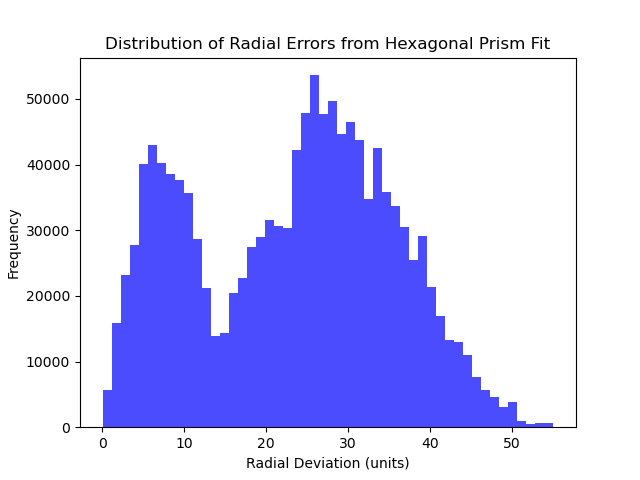

In [50]:
def compute_hexagonal_fit_error(mesh, principal_axis, prism_center):
    """
    Computes the standard deviation of radial distances from mesh points to an ideal hexagonal prism.

    Parameters:
    - mesh (o3d.geometry.TriangleMesh): The input 3D mesh.
    - principal_axis (np.ndarray): The computed unit vector of the prism's central axis.
    - prism_center (np.ndarray): The center of the prism.

    Returns:
    - std_dev_radial (float): The standard deviation of radial deviations from the hexagonal model.
    """
    # Extract vertices
    vertices = np.asarray(mesh.vertices)

    # Project vertices onto the principal axis to get their height along the prism
    heights = np.dot(vertices - prism_center, principal_axis)

    # Reconstruct projected points on the principal axis
    projected_points = np.outer(heights, principal_axis) + prism_center

    # Compute radial deviations (perpendicular distances from projected axis)
    radial_deviations = np.linalg.norm(vertices - projected_points, axis=1)

    # Compute standard deviation of radial distances
    std_dev_radial = np.std(radial_deviations)

    return std_dev_radial, radial_deviations

# Compute error
std_dev_error, deviations = compute_hexagonal_fit_error(mesh_e, prism_axis, prism_center)

print("Standard Deviation of Radial Fit Error:", std_dev_error)

plt.hist(deviations, bins=50, alpha=0.7, color='b')
plt.xlabel("Radial Deviation (units)")
plt.ylabel("Frequency")
plt.title("Distribution of Radial Errors from Hexagonal Prism Fit")
plt.show()


In [26]:

# Filter the mesh
mesh_cyl_e = fun.filter_mesh_by_cylinder(mesh_e, cylinder_radius_e, cylinder_height_e, cylinder_center_e)

# Visualize the result
fun.visualize_filtered_mesh(mesh_cyl_e)

# output_file = 'meshes/mesh_cyl_v1.obj'  # Specify the path where you want to save the mesh
# o3d.io.write_triangle_mesh(output_file, mesh_cyl)
# print(f"Filtered mesh saved to {output_file}")

### find axis of plumbbob

In [27]:

def find_cylinder_axis_and_center2(point_cloud):
    """
    Given a dense point cloud, this function returns the axis direction and center of a cylinder-like structure.
    It uses PCA (Principal Component Analysis) to find the axis and calculates the center as the mean of the points.
    
    Parameters:
    - point_cloud (open3d.geometry.PointCloud): The input point cloud to process.
    
    Returns:
    - tuple: (cylinder_axis, cylinder_center)
      - cylinder_axis (numpy.ndarray): The direction of the cylinder's axis.
      - cylinder_center (numpy.ndarray): The center of the cylinder.
    """
    # Extract the points from the point cloud
    points = np.asarray(point_cloud.points)

    # Run PCA to find the central axis
    pca = PCA(n_components=2)
    pca.fit(points)

    # Get the direction of the principal component (the cylinder's axis)
    cylinder_axis = pca.components_[0]  # The first component is the direction of the axis

    # The center of the cylinder can be estimated as the mean of the points
    cylinder_center = np.mean(points, axis=0)

    # Optionally, visualize the cylinder axis along with the point cloud
    line_set = o3d.geometry.LineSet()
    line_set.points = o3d.utility.Vector3dVector([cylinder_center, cylinder_center + 10 * cylinder_axis])  # Example line length
    line_set.lines = o3d.utility.Vector2iVector([[0, 1]])

    # Visualize the point cloud with the cylinder axis
    o3d.visualization.draw_geometries([point_cloud, line_set])

    return cylinder_axis, cylinder_center


In [28]:
# mesh_cyl_file = 'meshes/mesh_cyl_v1.obj'
# mesh_cyl = o3d.io.read_triangle_mesh(mesh_cyl_file)
cylinder_axis, cylinder_center = fun.find_cylinder_axis_and_center(mesh_cyl)

print("Cylinder axis direction:", cylinder_axis)
print("Cylinder center:", cylinder_center)


Cylinder axis direction: [ 4.60132695e-04 -3.49293452e-03 -9.99993794e-01]
Cylinder center: [-0.74441184 -1.65508627  9.11054752]


In [2]:
cylinder_axis = [4.60132695e-04, -3.49293452e-03, -9.99993794e-01]
cylinder_center = [-0.74441184, -1.65508627, 9.11054752]

In [29]:
# mesh_cyl_file = 'meshes/mesh_cyl_v1.obj'
# mesh_cyl = o3d.io.read_triangle_mesh(mesh_cyl_file)
cylinder_axis_pcd, cylinder_center_pcd = find_cylinder_axis_and_center2(pcd_cyl)

print("Cylinder axis direction:", cylinder_axis_pcd)
print("Cylinder center:", cylinder_center_pcd)


Cylinder axis direction: [ 7.70243156e-04 -2.13837326e-03 -9.99997417e-01]
Cylinder center: [-0.7441862  -1.65392865  9.15884828]


In [3]:
cylinder_axis_pcd = [ 7.70243156e-04, -2.13837326e-03, -9.99997417e-01]
cylinder_center_pcd = [-0.7441862,  -1.65392865,  9.15884828]

In [30]:
# mesh_cyl_file = 'meshes/mesh_cyl_v1.obj'
# mesh_cyl = o3d.io.read_triangle_mesh(mesh_cyl_file)
cylinder_axis_pcd_e, cylinder_center_pcd_e = find_cylinder_axis_and_center2(pcd_cyl_e)

print("Cylinder axis direction:", cylinder_axis_pcd_e)
print("Cylinder center:", cylinder_center_pcd_e)


Cylinder axis direction: [ 0.00820957  0.00177146 -0.99996473]
Cylinder center: [-4.40498346  2.50811467 13.21803414]


In [4]:
cylinder_axis_pcd_e = [ 0.00820957,  0.00177146, -0.99996473]
cylinder_center_pcd_e = [-4.40498346,  2.50811467, 13.21803414]

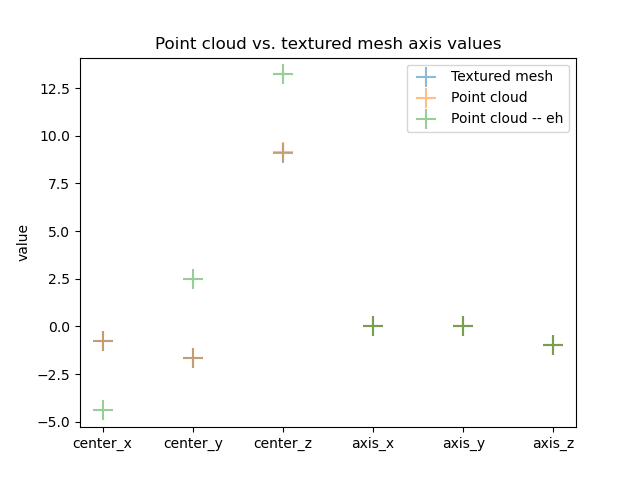

In [5]:
plt.figure()

x = ['center_x','center_y','center_z','axis_x','axis_y','axis_z']
y = np.concatenate((cylinder_center,cylinder_axis))
y_2 = np.concatenate((cylinder_center_pcd,cylinder_axis_pcd))
y_3 = np.concatenate((cylinder_center_pcd_e,cylinder_axis_pcd_e))
plt.scatter(x,y, alpha=0.5, marker='+', s=200, label='Textured mesh')
plt.scatter(x,y_2, alpha=0.5, marker='+', s=200, label='Point cloud')
plt.scatter(x,y_3, alpha=0.5, marker='+', s=200, label='Point cloud -- eh')
plt.legend()
plt.ylabel('value')
plt.title('Point cloud vs. textured mesh axis values')
plt.show()

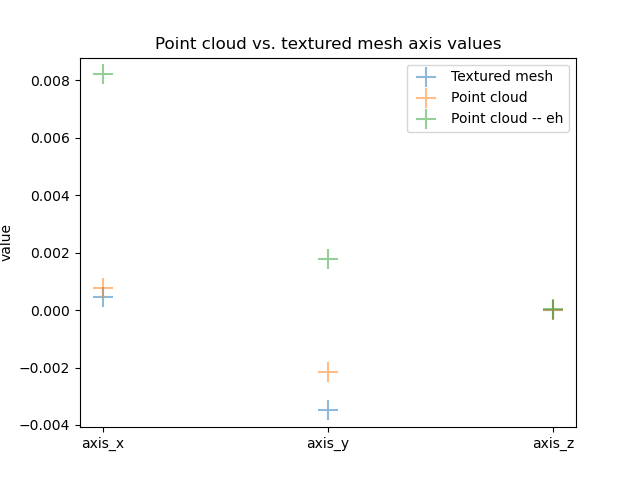

In [46]:
plt.figure()

w = ['axis_x','axis_y','axis_z']
z = cylinder_axis
z_hat = [0,0,1]
z_2 = cylinder_axis_pcd
z_3 = cylinder_axis_pcd_e
plt.scatter(w,z+z_hat, alpha=0.5, marker='+', s=200, label='Textured mesh')
plt.scatter(w,z_2+z_hat, alpha=0.5, marker='+', s=200, label='Point cloud')
plt.scatter(w,z_3+z_hat, alpha=0.5, marker='+', s=200, label='Point cloud -- eh')
plt.legend()
plt.ylabel('value')
plt.title('Point cloud vs. textured mesh axis values')
plt.show()

In [ ]:
plt.close()

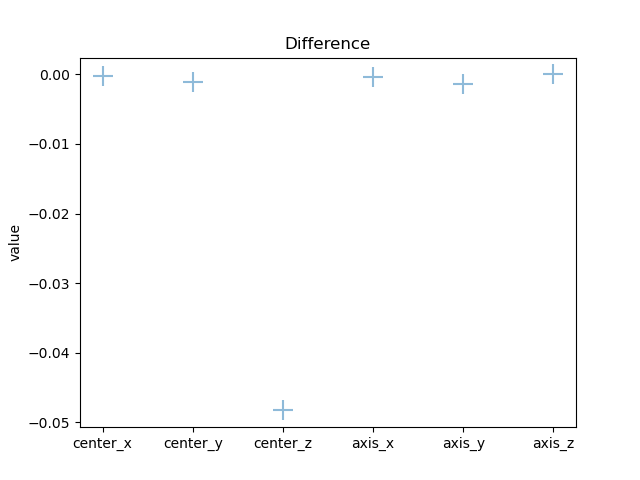

In [51]:
plt.figure()
plt.scatter(x,(y-y_2), alpha=0.5, marker='+', s=200, label='Delta')
# plt.scatter(x,y_2, alpha=0.5, marker='+', s=200, label='Point cloud')
plt.ylabel('value')
plt.title('Difference')
plt.show()

In [31]:


dot_product = np.dot(cylinder_axis, cylinder_axis_pcd)
norm_cylinder_axis = np.linalg.norm(cylinder_axis)
norm_cylinder_axis_pcd = np.linalg.norm(cylinder_axis_pcd)

# Compute the cosine of the angle
cos_theta = dot_product / (norm_cylinder_axis * norm_cylinder_axis_pcd)

# Compute the angle in radians
angle_rad = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to handle numerical errors

# Convert the angle to degrees
angle_deg = np.degrees(angle_rad)
print(dot_product)
print(angle_deg)

0.9999990344910874
0.07961883319971501


In [52]:


dot_product = np.dot(cylinder_axis_pcd, cylinder_axis_pcd_e)
norm_cylinder_axis = np.linalg.norm(cylinder_axis_pcd)
norm_cylinder_axis_pcd = np.linalg.norm(cylinder_axis_pcd_e)

# Compute the cosine of the angle
cos_theta = dot_product / (norm_cylinder_axis * norm_cylinder_axis_pcd)

# Compute the angle in radians
angle_rad = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to handle numerical errors

# Convert the angle to degrees
angle_deg = np.degrees(angle_rad)
print(dot_product)
print(angle_deg)

0.999964684290736
0.4815294736959893


In [9]:
# Example usage:
cylinder_axis, cylinder_center, cylinder_radius = fun.find_cylinder_axis_center_radius(mesh_cyl)
print("Cylinder axis:", cylinder_axis)
print("Cylinder center:", cylinder_center)
print("Cylinder radius:", cylinder_radius)

NameError: name 'mesh_cyl' is not defined

In [33]:
# Example usage:
cylinder_axis_pcd, cylinder_center_pcd, cylinder_radius_pcd = geoms.find_cylinder_axis_center_radius(pcd_cyl)
print("Cylinder axis:", cylinder_axis_pcd)
print("Cylinder center:", cylinder_center_pcd)
print("Cylinder radius:", cylinder_radius_pcd)

Cylinder axis: [ 7.70243156e-04 -2.13837326e-03 -9.99997417e-01]
Cylinder center: [-0.7441862  -1.65392865  9.15884828]
Cylinder radius: 0.10277935815565378


In [34]:
# Example usage:
cylinder_axis_pcd_e, cylinder_center_pcd_e, cylinder_radius_pcd_e = geoms.find_cylinder_axis_center_radius(pcd_cyl_e)
print("Cylinder axis:", cylinder_axis_pcd_e)
print("Cylinder center:", cylinder_center_pcd_e)
print("Cylinder radius:", cylinder_radius_pcd_e)

Cylinder axis: [ 0.00820957  0.00177146 -0.99996473]
Cylinder center: [-4.40498346  2.50811467 13.21803414]
Cylinder radius: 0.03957530413641009


In [35]:
# Example usage:
variance = geoms.compute_cylinder_variance(mesh_cyl, cylinder_axis, cylinder_center, cylinder_radius)
print(f"Variance in distance from ideal cylinder: {variance}")


Variance in distance from ideal cylinder: 0.5186573089118445


In [36]:
# Example usage:
variance = geoms.compute_cylinder_variance(pcd_cyl, cylinder_axis_pcd, cylinder_center_pcd, cylinder_radius_pcd)
print(f"Variance in distance from ideal cylinder: {variance}")


Variance in distance from ideal cylinder: 8.911006631584263e-08


In [37]:
# Example usage:
variance = geoms.compute_cylinder_variance(pcd_cyl_e, cylinder_axis_pcd_e, cylinder_center_pcd_e, cylinder_radius_pcd_e)
print(f"Variance in distance from ideal cylinder: {variance}")


Variance in distance from ideal cylinder: 1.619600288085942e-07


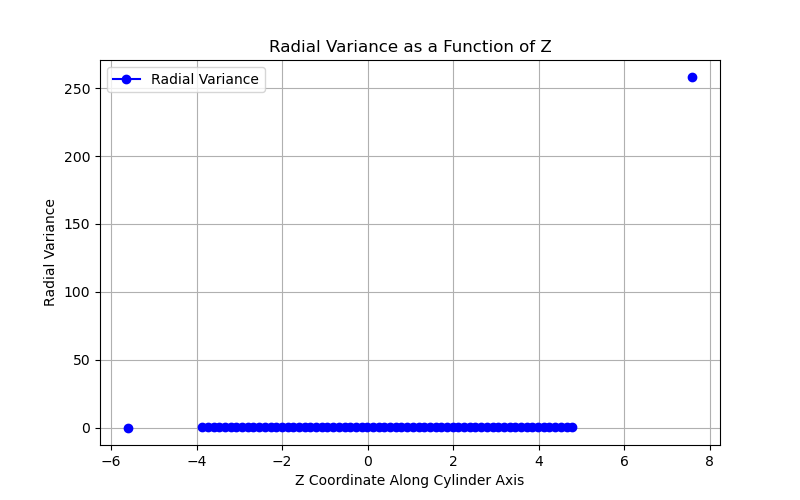

In [38]:
# Example usage:
bin_centers, binned_variances = geoms.compute_and_plot_binned_cylinder_variance(mesh_cyl, cylinder_axis, 
                                                                                cylinder_center, cylinder_radius,
                                                                               num_bins=100)



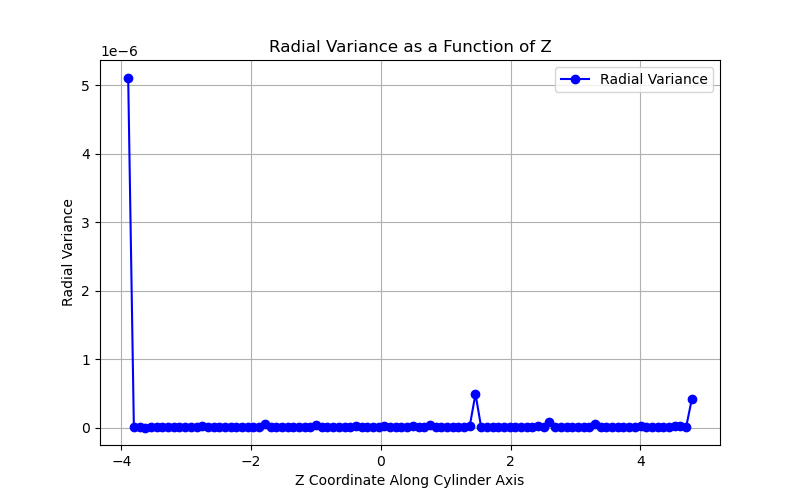

In [39]:
# Example usage:
bin_centers, binned_variances = geoms.compute_and_plot_binned_cylinder_variance(pcd_cyl, cylinder_axis_pcd, 
                                                                                cylinder_center_pcd, cylinder_radius_pcd,
                                                                               num_bins=100)



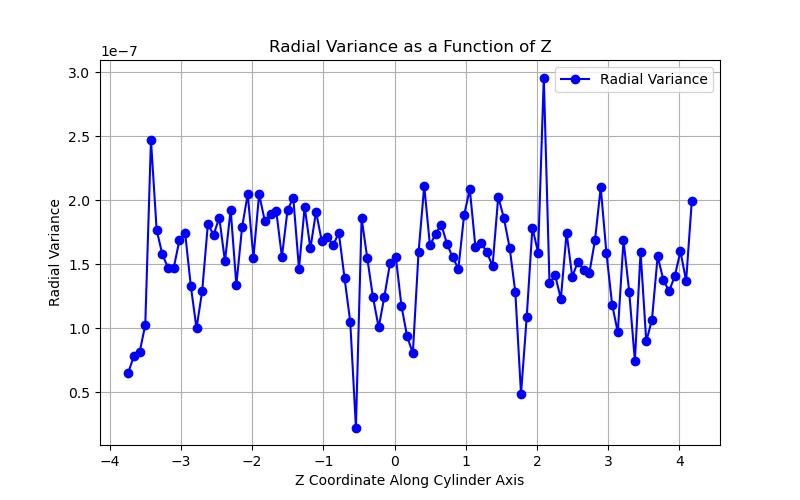

In [40]:
# Example usage:
bin_centers, binned_variances = geoms.compute_and_plot_binned_cylinder_variance(pcd_cyl_e, cylinder_axis_pcd_e, 
                                                                                cylinder_center_pcd_e, cylinder_radius_pcd_e,
                                                                               num_bins=100)



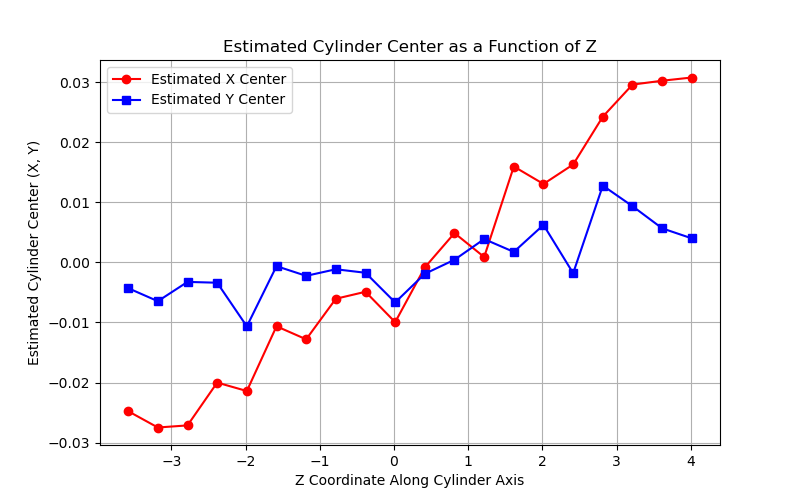

In [42]:

# Example usage:
bin_centers, binned_x_centers, binned_y_centers = geoms.compute_and_plot_binned_cylinder_center(pcd_cyl_e, cylinder_axis_pcd_e, cylinder_center_pcd_e)


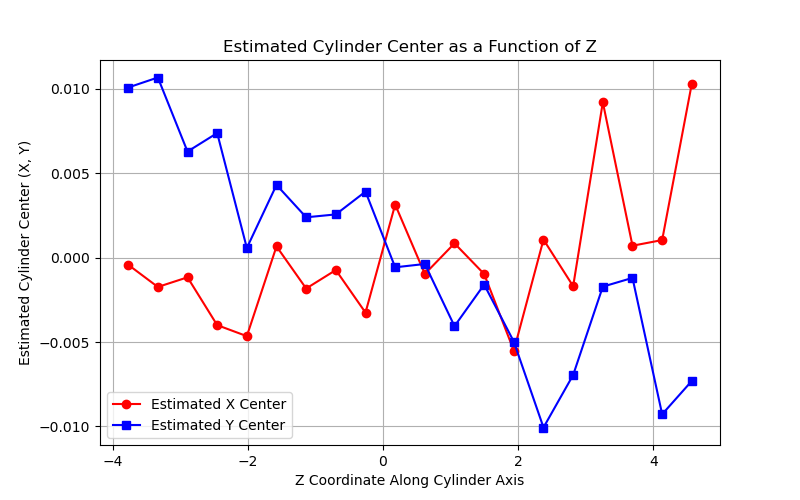

In [43]:
bin_centers, binned_x_centers, binned_y_centers = geoms.compute_and_plot_binned_cylinder_center(pcd_cyl, cylinder_axis, cylinder_center)


In [271]:
points = np.asarray(pcd_cyl.points)#-np.array([1,0,0])
points

array([[-0.81605441, -1.72028275,  6.22841756],
       [-0.84519173, -1.70623211,  9.84942173],
       [-0.84320924, -1.70877962,  9.86666659],
       ...,
       [-0.84918512, -1.64179033,  9.68977409],
       [-0.80098466, -1.73321592, 12.92985393],
       [-0.78744658, -1.74505948, 10.34106833]])

In [279]:
importlib.reload(geoms)

<module 'geoms' from '/Users/ehealy/Chicago/Simons_II/photopol/geoms.py'>

In [87]:
# mesh_cyl_file = 'meshes/mesh_cyl_v1.obj'
# mesh_cyl = o3d.io.read_triangle_mesh(mesh_cyl_file)
cylinder_axis_e, cylinder_center_e = fun.find_cylinder_axis_and_center(mesh_cyl_e)

print("Cylinder axis direction:", cylinder_axis)
print("Cylinder center:", cylinder_center)


Cylinder axis direction: [ 0.00840463  0.00185568 -0.99996296]
Cylinder center: [-4.40382831  2.50867643 13.06655607]


In [62]:
# mesh_cyl_file = 'meshes/mesh_cyl_v1.obj'
# mesh_cyl = o3d.io.read_triangle_mesh(mesh_cyl_file)
cylinder_axis_e, cylinder_center_e = fun.find_cylinder_axis_and_center(mesh_cyl_e)

print("Cylinder axis direction:", cylinder_axis_e)
print("Cylinder center:", cylinder_center_e)


Cylinder axis direction: [ 0.00860801  0.00179287 -0.99996134]
Cylinder center: [-4.39938056  2.50945594 12.57784207]


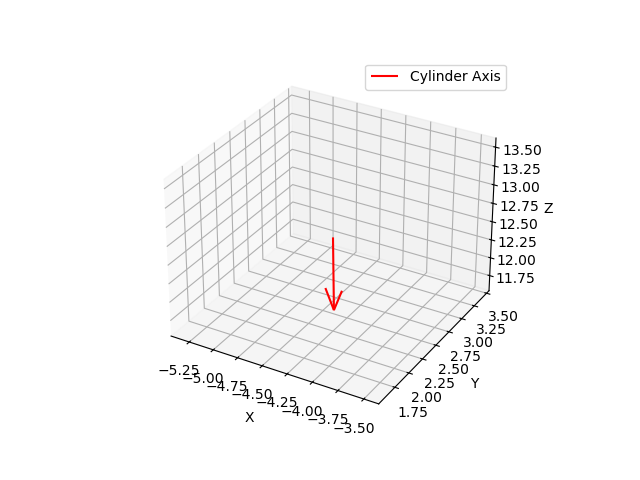

In [63]:
fun.plot_cylinder_axis(cylinder_center_e, cylinder_axis_e)

# extracting plate geometry

### define bounds for plate

In [27]:
# Define the bounding box (min_bound and max_bound are [x, y, z] coordinates)
min_bound = np.array([-2.9, -3.7, -5])  # Minimum bound in the x, y, z directions
max_bound = np.array([1.3, 0.5, 2])     # Maximum bound in the x, y, z directions

# Filter the mesh
mesh_plate = fun.filter_mesh_by_bounding_box(mesh, min_bound, max_bound)


In [34]:
# Define the bounding box (min_bound and max_bound are [x, y, z] coordinates)
min_bound = np.array([-2.9, -3.7, -5])  # Minimum bound in the x, y, z directions
max_bound = np.array([1.3, 0.5, 2])     # Maximum bound in the x, y, z directions

# Filter the mesh
mesh_plate_e = fun.filter_mesh_by_bounding_box(mesh_e, min_bound, max_bound)


[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.


In [28]:

min_bound = np.array([-2.9, -3.7, -5])  # Minimum bound in the x, y, z directions
max_bound = np.array([1.3, 0.5, 2])     # Maximum bound in the x, y, z directions

# Filter the mesh
mesh_plate = fun.filter_mesh_by_box(mesh, min_bound, max_bound)

# Visualize the result
o3d.visualization.draw_geometries([mesh_plate])


In [29]:


# Assuming the mesh has already been filtered to a plane
normal_vector = fun.find_plane_normal(mesh_plate)
print("Normal to the plane:", normal_vector)


Normal to the plane: [-0.00487037 -0.00628235 -0.99996841]


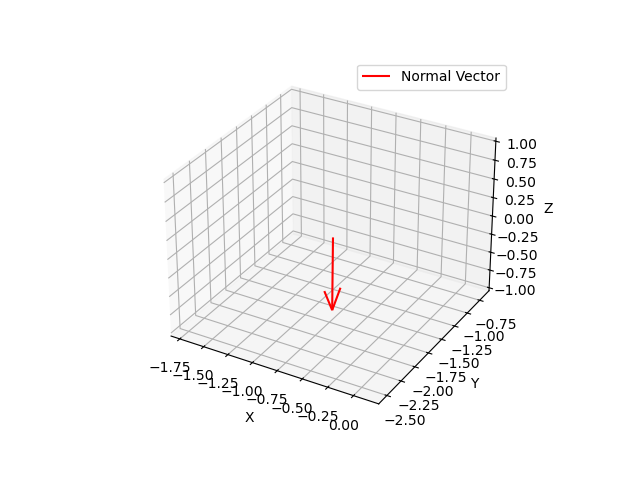

In [30]:
normal_centroid = [(max_bound[0]+min_bound[0])/2,(max_bound[1]+min_bound[1])/2,0]
fun.plot_normal_vector(normal_centroid, normal_vector)

# find relative geometries of plate and plumbbob

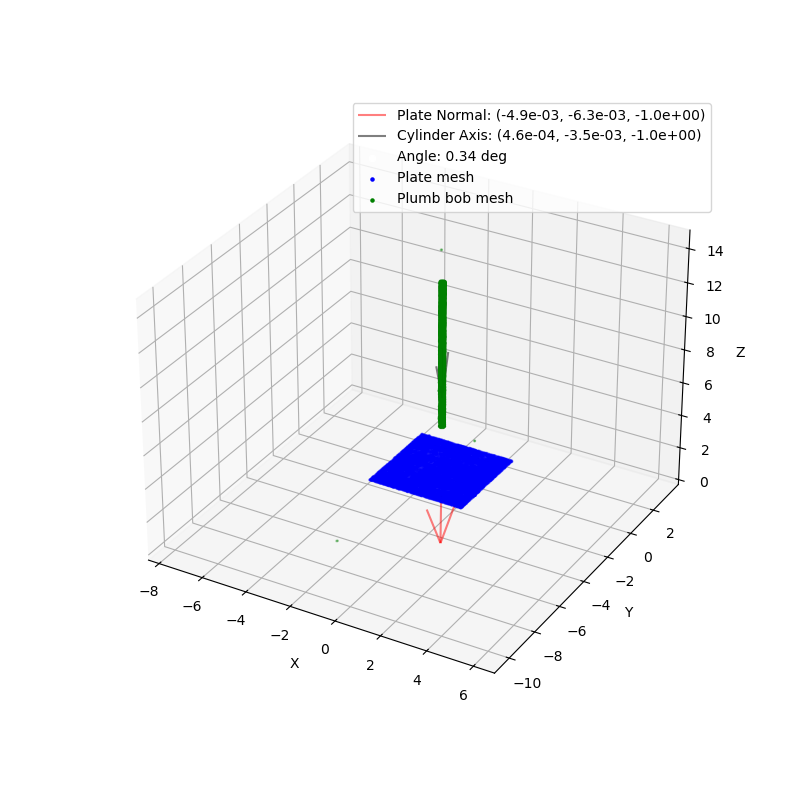

In [31]:
fun.plot_meshes_with_vectors(mesh_plate, normal_vector, normal_centroid, 
                         mesh_cyl, cylinder_axis, cylinder_center)

In [16]:
# find angle between plate and plumbbob
angle = fun.angle_between_vectors(normal_vector, cylinder_axis)
print("Angle between vectors:", angle, "degrees")


Angle between vectors: 0.34470868327113374 degrees
